In [1]:
import swyft
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class FakeLISA(swyft.Simulator):
    def __init__(self, nbins=100, nparams=4):
        super().__init__()
        self.f = np.geomspace(3e-5, 5e-1, nbins)
        self.nbins = nbins
        self.nparams = nparams
        self.bounds = np.array(
            [[-1.0, 1.0], [-6.0, 2.0], [0.0, 6.0], [0.0, 30.0]]
        )
        self.transform_samples = swyft.to_numpy32

    def get_z(self):
        return np.random.uniform(self.bounds[:, 0], self.bounds[:, 1])

    def get_noise_template(self, z):
        temp_noise = (z[2] / 3.0) ** 2 * (self.f / 1e-3) ** (-6) + (
            z[3] / 15.0
        ) ** 2 * (self.f / 1e-3) ** 2
        return temp_noise

    def get_signal_template(self, z):
        temp_signal = 10 ** z[0] * (self.f / 1e-3) ** z[1]
        return temp_signal

    def get_data(self, temp_noise, temp_signal):
        return np.random.normal(0.0, np.sqrt(temp_noise + temp_signal))

    def build(self, graph):
        z = graph.node("z", self.get_z)
        temp_noise = graph.node("temp_noise", self.get_noise_template, z)
        temp_signal = graph.node("temp_signal", self.get_signal_template, z)
        data = graph.node("data", self.get_data, temp_noise, temp_signal)

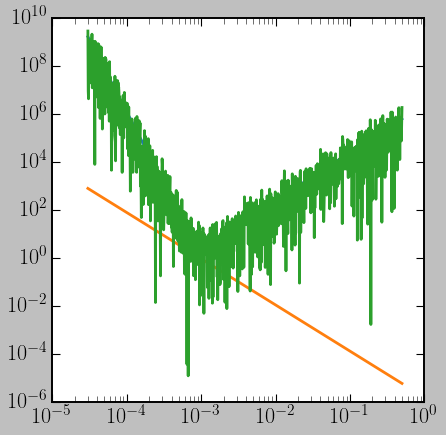

In [3]:
sim = FakeLISA(nbins=1000)
sample = sim.sample()
plt.loglog(sim.f, sample["temp_noise"])
plt.loglog(sim.f, sample["temp_signal"])
plt.loglog(sim.f, sample["data"] ** 2)

In [4]:
database = sim.sample(10000)

100%|██████████| 10000/10000 [00:00<00:00, 14767.55it/s]


In [5]:
sigmas = np.std(database["data"], axis=0)
sigmas2 = np.sqrt(
    sim.sample(
        conditions={"z": np.array([0.0, 0.0, 3.0, 15.0])},
        targets=["temp_noise"],
    )["temp_noise"]
)
sigmas3 = np.mean(database['temp_signal'], axis=0)

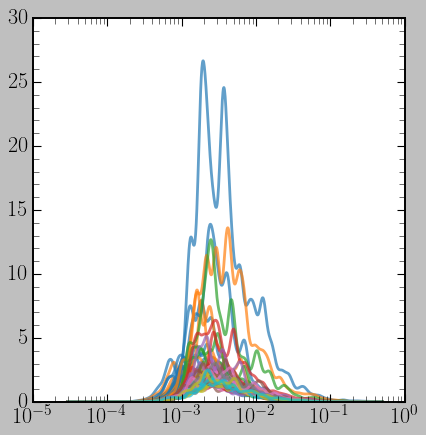

In [6]:
from scipy.ndimage import gaussian_filter1d
for tilt in np.linspace(-6.0, 2.0, 10):
    for amp in np.linspace(-1.0, 1.0, 10)[::-1]:    
        sample = sim.sample(conditions={"z": np.array([amp, tilt, 3.0, 15.0])})
        plt.semilogx(sim.f, gaussian_filter1d(sample["data"] ** 2 / sigmas3**2, sigma=10.), alpha=0.7)
# plt.semilogx(sim.f, sample["temp_signal"] / sigmas2**2)
# plt.semilogx(sim.f, sample["temp_noise"] / sigmas2**2)

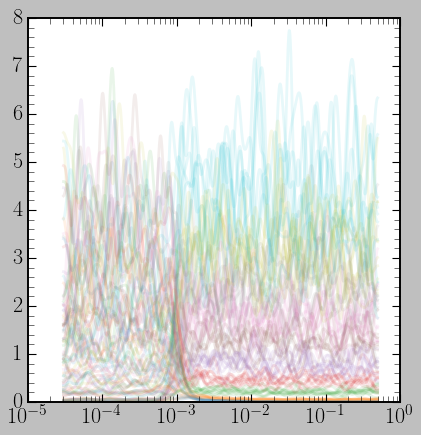

In [7]:
from scipy.ndimage import gaussian_filter1d
for TM in np.linspace(0., 6.0, 10):
    for OMS in np.linspace(0.0, 30.0, 10):    
        sample = sim.sample(conditions={"z": np.array([-1.0, 1.0, TM, OMS])})
        plt.semilogx(sim.f, gaussian_filter1d(sample["data"] ** 2 / sigmas2**2, sigma=10.), alpha=0.1)

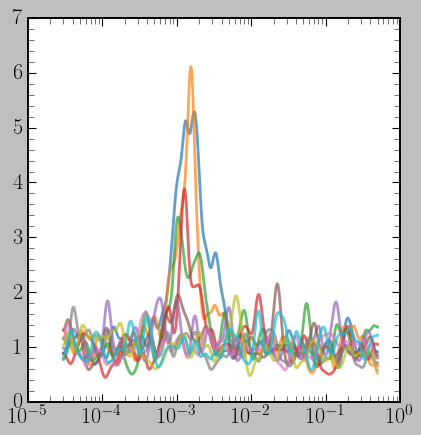

In [8]:
from scipy.ndimage import gaussian_filter1d
for amp in np.linspace(-1.0, 1.0, 10)[::-1]:    
    sample = sim.sample(conditions={"z": np.array([amp, 0.0, 3.0, 15.0])})
    plt.semilogx(sim.f, gaussian_filter1d(sample["data"] ** 2 / sigmas2**2, sigma=10.), alpha=0.7)

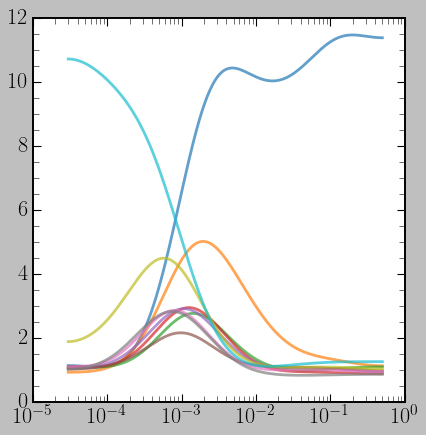

In [9]:
for tilt in np.linspace(-6.0, 2.0, 10)[::-1]:    
    sample = sim.sample(conditions={"z": np.array([1.0, tilt, 3.0, 15.0])})
    plt.semilogx(sim.f, gaussian_filter1d(sample["data"] ** 2 / sigmas2**2, sigma=100.), alpha=0.7)

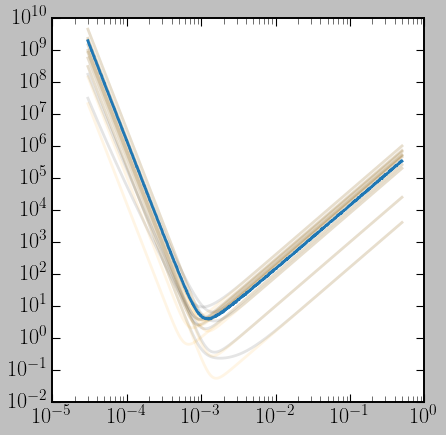

In [10]:
for i in range(10):
    sample = sim.sample(targets=["z", "temp_noise", "temp_signal"])
    plt.loglog(
        sim.f, sample["temp_noise"] + sample["temp_signal"], c="k", alpha=0.1
    )
    plt.loglog(sim.f, sample["temp_noise"], c="orange", alpha=0.1)
plt.plot(sim.f, sigmas**2)

In [12]:
from typing import Any
from swyft.networks import OnlineStandardizingLayer


class InferenceNetwork(swyft.SwyftModule, swyft.AdamWReduceLROnPlateau):
    def __init__(self, est_sigmas, sim):
        super().__init__()
        self.sigmas = est_sigmas
        self.sim = sim
        self.learning_rate = 1e-4
        self.num_feat_param = 2
        self.num_params = sim.nparams
        self.fc1 = nn.Linear(sim.nbins, self.num_feat_param * sim.nparams)
        self.fc2 = nn.Linear(sim.nbins, self.num_feat_param * sim.nparams)
        self.marginals = self.get_marginals(sim.nparams)
        self.lrs1d = swyft.LogRatioEstimator_1dim(
            num_features=self.num_feat_param,
            num_params=self.num_params,
            varnames="z",
            # num_blocks=4,
            # dropout=0.1,
        )
        self.lrs2d = swyft.LogRatioEstimator_Ndim(
            num_features=2 * self.num_feat_param,
            marginals=self.marginals,
            varnames="z",
            # num_blocks=4,
            # dropout=0.1,
        )
        self.nl1 = OnlineStandardizingLayer(shape=(sim.nbins,))
        self.nl2 = OnlineStandardizingLayer(shape=(sim.nbins,))

    def forward(self, A, B):
        score_input = self.nl1(
            torch.tensor(gaussian_filter1d(A["data"] ** 2 / sigmas2**2, sigma=10.))  # - (1.0 / self.sigmas)
        )
        score_compression = self.fc1(score_input)
        # score_compression = torch.cat((score_compression_signal, score_compression_noise), dim=1)
        s1 = score_compression.reshape(
            -1, self.num_params, self.num_feat_param
        )  # (batch, num_params, num_feat_param)
        s2 = torch.stack(
            [
                torch.cat([s1[:, i, :], s1[:, j, :]], dim=-1)
                for i, j in self.marginals
            ],
            dim=1,
        )
        lrs1d = self.lrs1d(s1, B["z"])
        lrs2d = self.lrs2d(s2, B["z"])
        return lrs1d, lrs2d

    @staticmethod
    def get_marginals(n_params):
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j > i:
                    marginals.append((i, j))
        return tuple(marginals)

In [13]:
trainer = swyft.SwyftTrainer(accelerator="cpu")
dm = swyft.SwyftDataModule(database, batch_size=64)
network = InferenceNetwork(sigmas2, sim)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [14]:
trainer.fit(network, dm)

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name  | Type                     | Params
---------------------------------------------------
0 | fc1   | Linear                   | 8.0 K 
1 | fc2   | Linear                   | 8.0 K 
2 | lrs1d | LogRatioEstimator_1dim   | 69.9 K
3 | lrs2d | LogRatioEstimator_Ndim   | 105 K 
4 | nl1   | OnlineStandardizingLayer | 0     
5 | nl2   | OnlineStandardizingLayer | 0     
---------------------------------------------------
191 K     Trainable params
0         Non-trainable params
191 K     Total params
0.768     Total estimated model params size (MB)


/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 12:  34%|███▍      | 53/157 [00:03<00:07, 13.73it/s, loss=-7.76, v_num=159, val_loss=-7.92] 

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [31]:
observation = sim.sample(conditions={"z": np.array([0.5, 1.0, 3.0, 15.0])})
prior_samples = sim.sample(targets=["z"], N=10000)

100%|██████████| 10000/10000 [00:00<00:00, 129801.17it/s]


In [60]:
lrs_out[1].parnames

array([['z[0]', 'z[1]'],
       ['z[0]', 'z[2]'],
       ['z[0]', 'z[3]'],
       ['z[1]', 'z[2]'],
       ['z[1]', 'z[3]'],
       ['z[2]', 'z[3]']], dtype='<U4')

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/swyft/plot/plot.py:236: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(K, K, figsize=figsize)
100%|██████████| 25/25 [00:33<00:00,  1.36s/it]


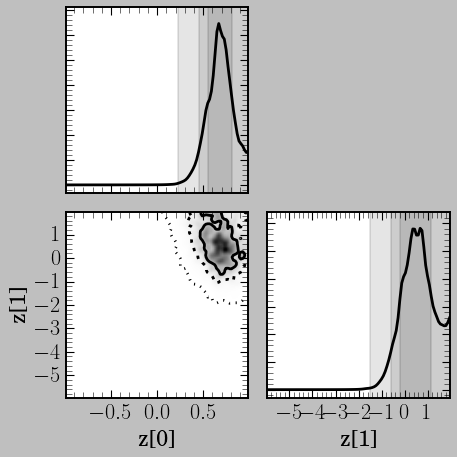

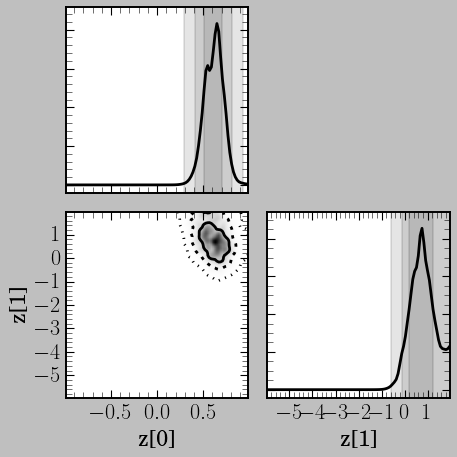

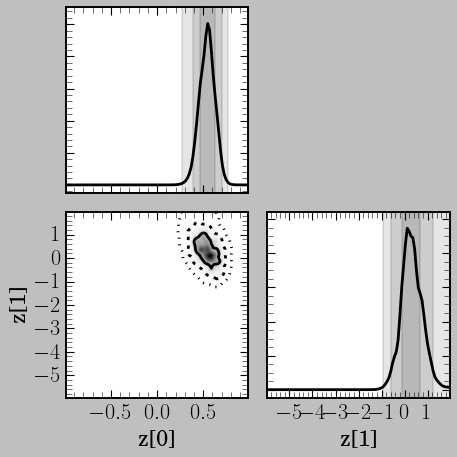

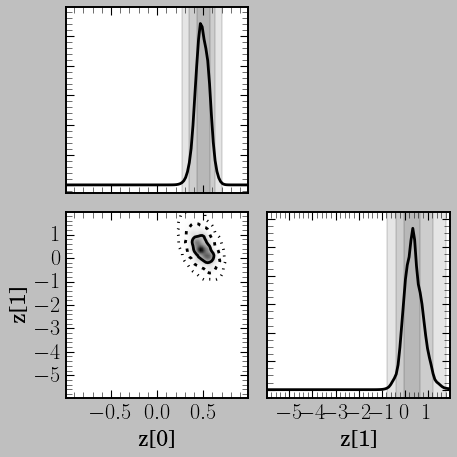

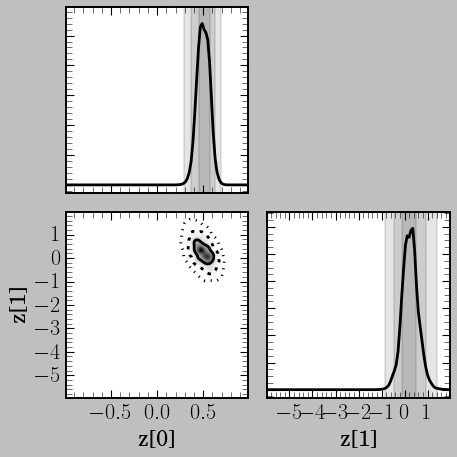

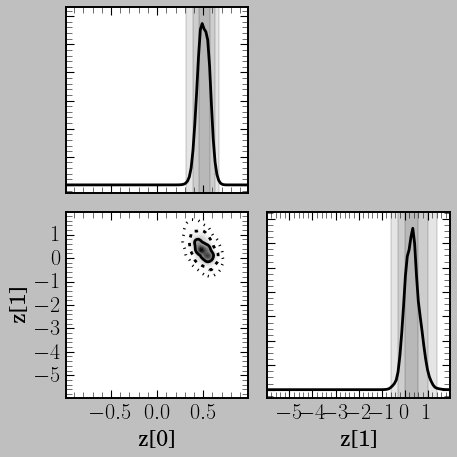

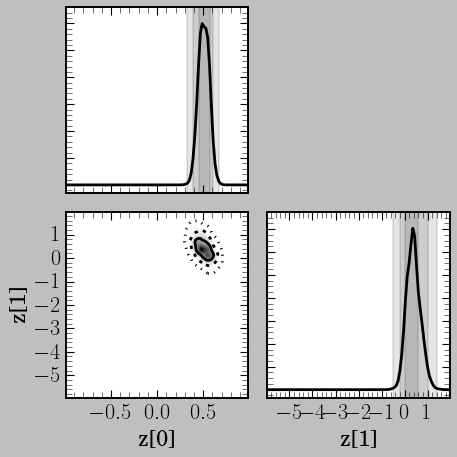

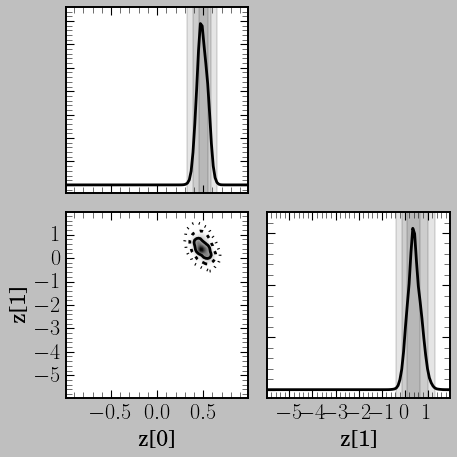

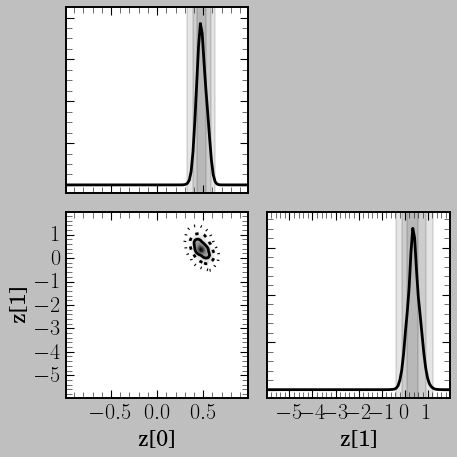

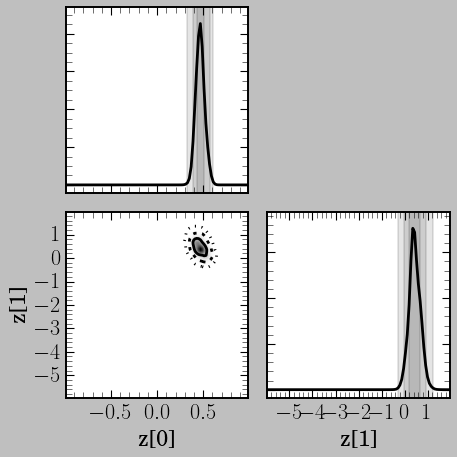

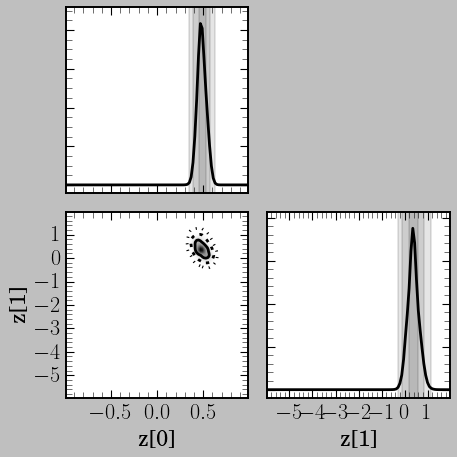

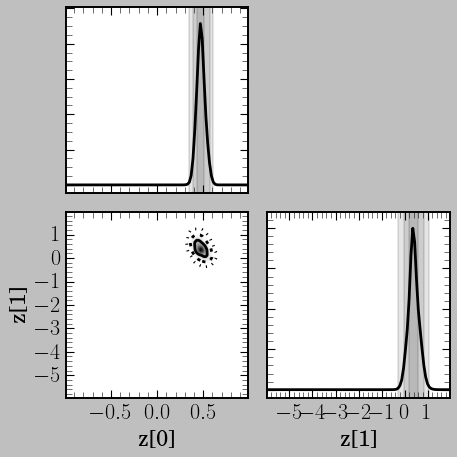

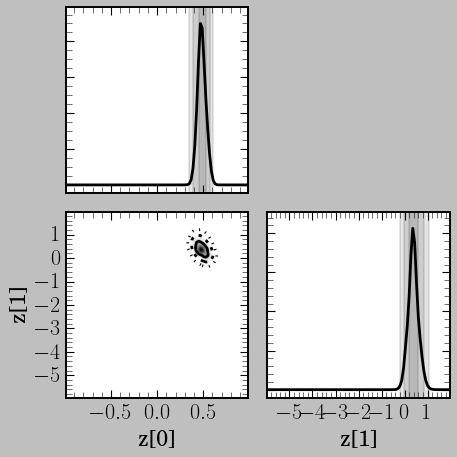

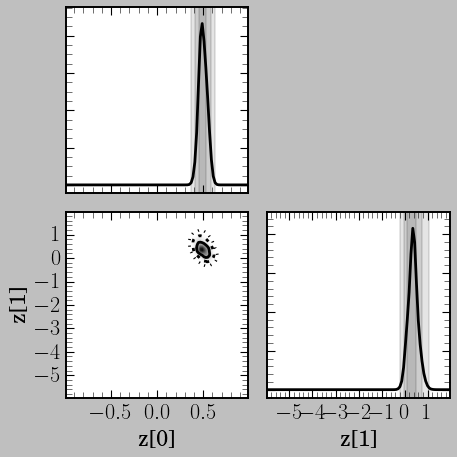

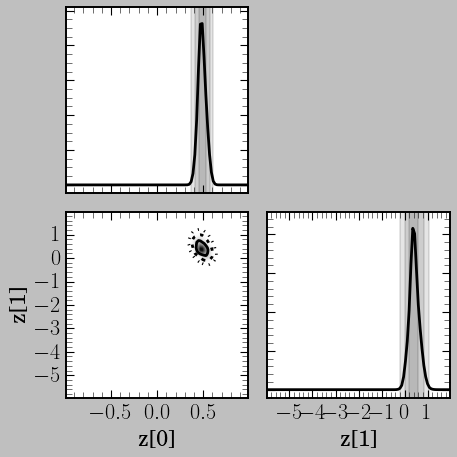

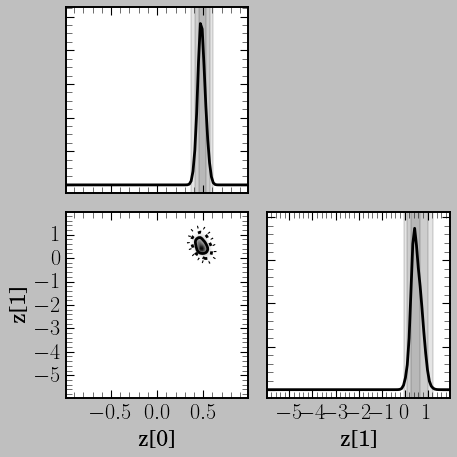

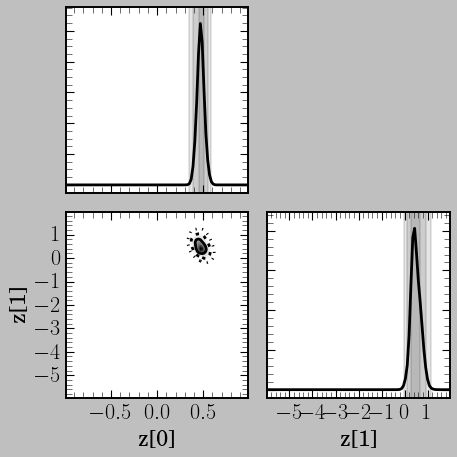

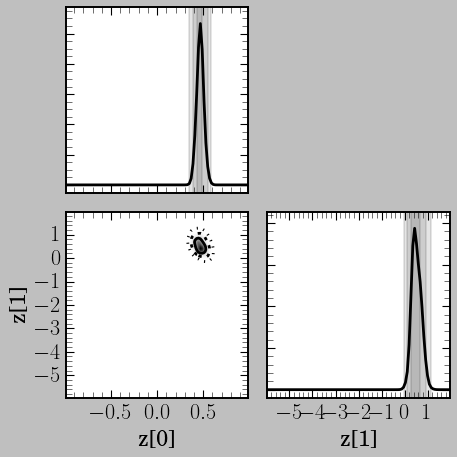

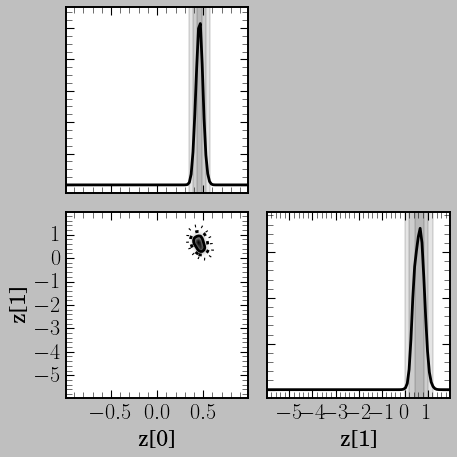

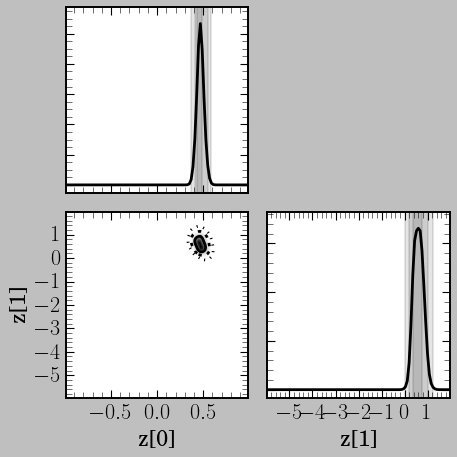

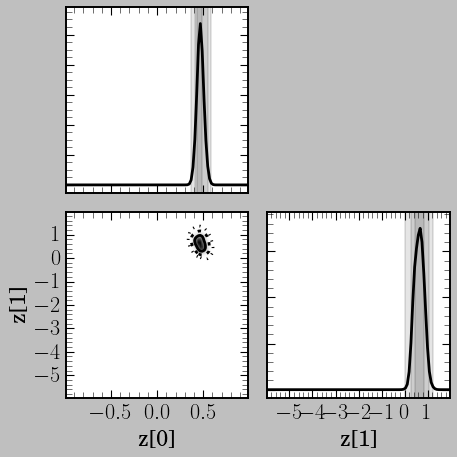

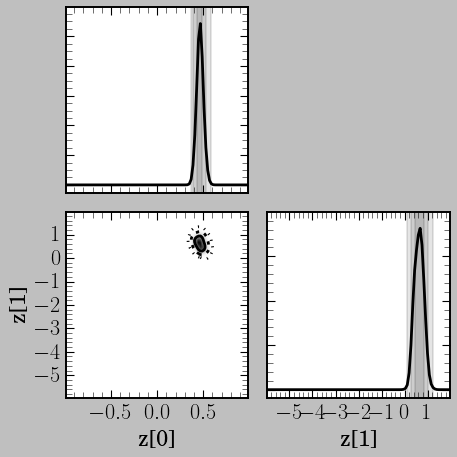

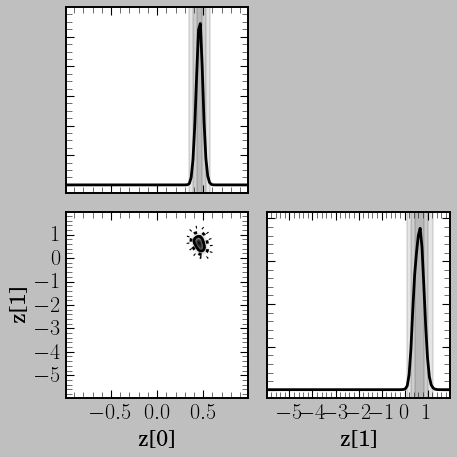

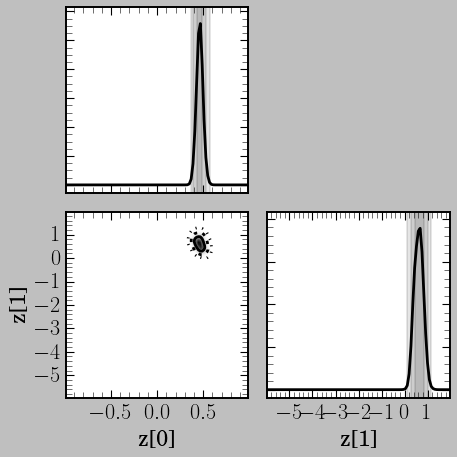

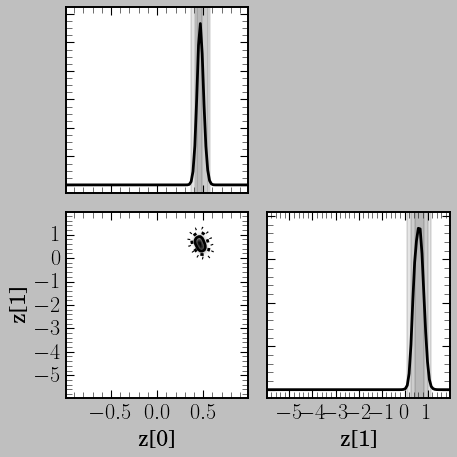

In [67]:
lrs_total = swyft.LogRatioSamples(
    logratios=torch.zeros((10000, 6)),
    params=torch.zeros((10000, 6, 2)),
    parnames=[
        ["z[0]", "z[1]"],
        ["z[0]", "z[2]"],
        ["z[0]", "z[3]"],
        ["z[1]", "z[2]"],
        ["z[1]", "z[3]"],
        ["z[2]", "z[3]"],
    ],
)
for i in tqdm.tqdm(range(25)):
    observation = sim.sample(conditions={"z": np.array([0.5, 1.0, 3.0, 15.0])})
    with torch.no_grad():
        network.eval()
        lrs_out = network(
            {"data": torch.tensor(observation["data"])},
            {"z": torch.tensor(prior_samples["z"])},
        )
    lrs_total.logratios += lrs_out[1].logratios
    lrs_total.params = lrs_out[1].params
    
    swyft.plot_corner(lrs_total, parnames=["z[0]", "z[1]",], smooth=1.2) 
                                           #"z[2]", "z[3]"])

In [32]:
pred_list = []
import tqdm
for i in tqdm.tqdm(range(20)):
    observation = sim.sample(conditions={"z": np.array([0.5, 1.0, 3.0, 15.0])})
    predictions = trainer.infer(network, observation, prior_samples)
    pred_list.append(predictions)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.04it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.33it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.32it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.32it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint



Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.35it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.34it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.99it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.22it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.35it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.23it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.27it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.12it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint



Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.32it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint



Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.15it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint



Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.22it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.29it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.32it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint



Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.33it/s]


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.27it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.24it/s]


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


In [33]:
lrs_1d = torch.zeros_like(pred_list[0][0].logratios)
params_1d = pred_list[0][0].params
lrs_2d = torch.zeros_like(pred_list[0][1].logratios)
params_2d = pred_list[0][1].params

In [34]:
for idx in range(len(pred_list)):
    lrs_1d += pred_list[idx][0].logratios
    lrs_2d += pred_list[idx][1].logratios

In [35]:
logratios_total_1d = swyft.LogRatioSamples(logratios=lrs_1d, params=params_1d, parnames=pred_list[0][0].parnames)
logratios_total_2d = swyft.LogRatioSamples(logratios=lrs_2d, params=params_2d, parnames=pred_list[0][1].parnames)

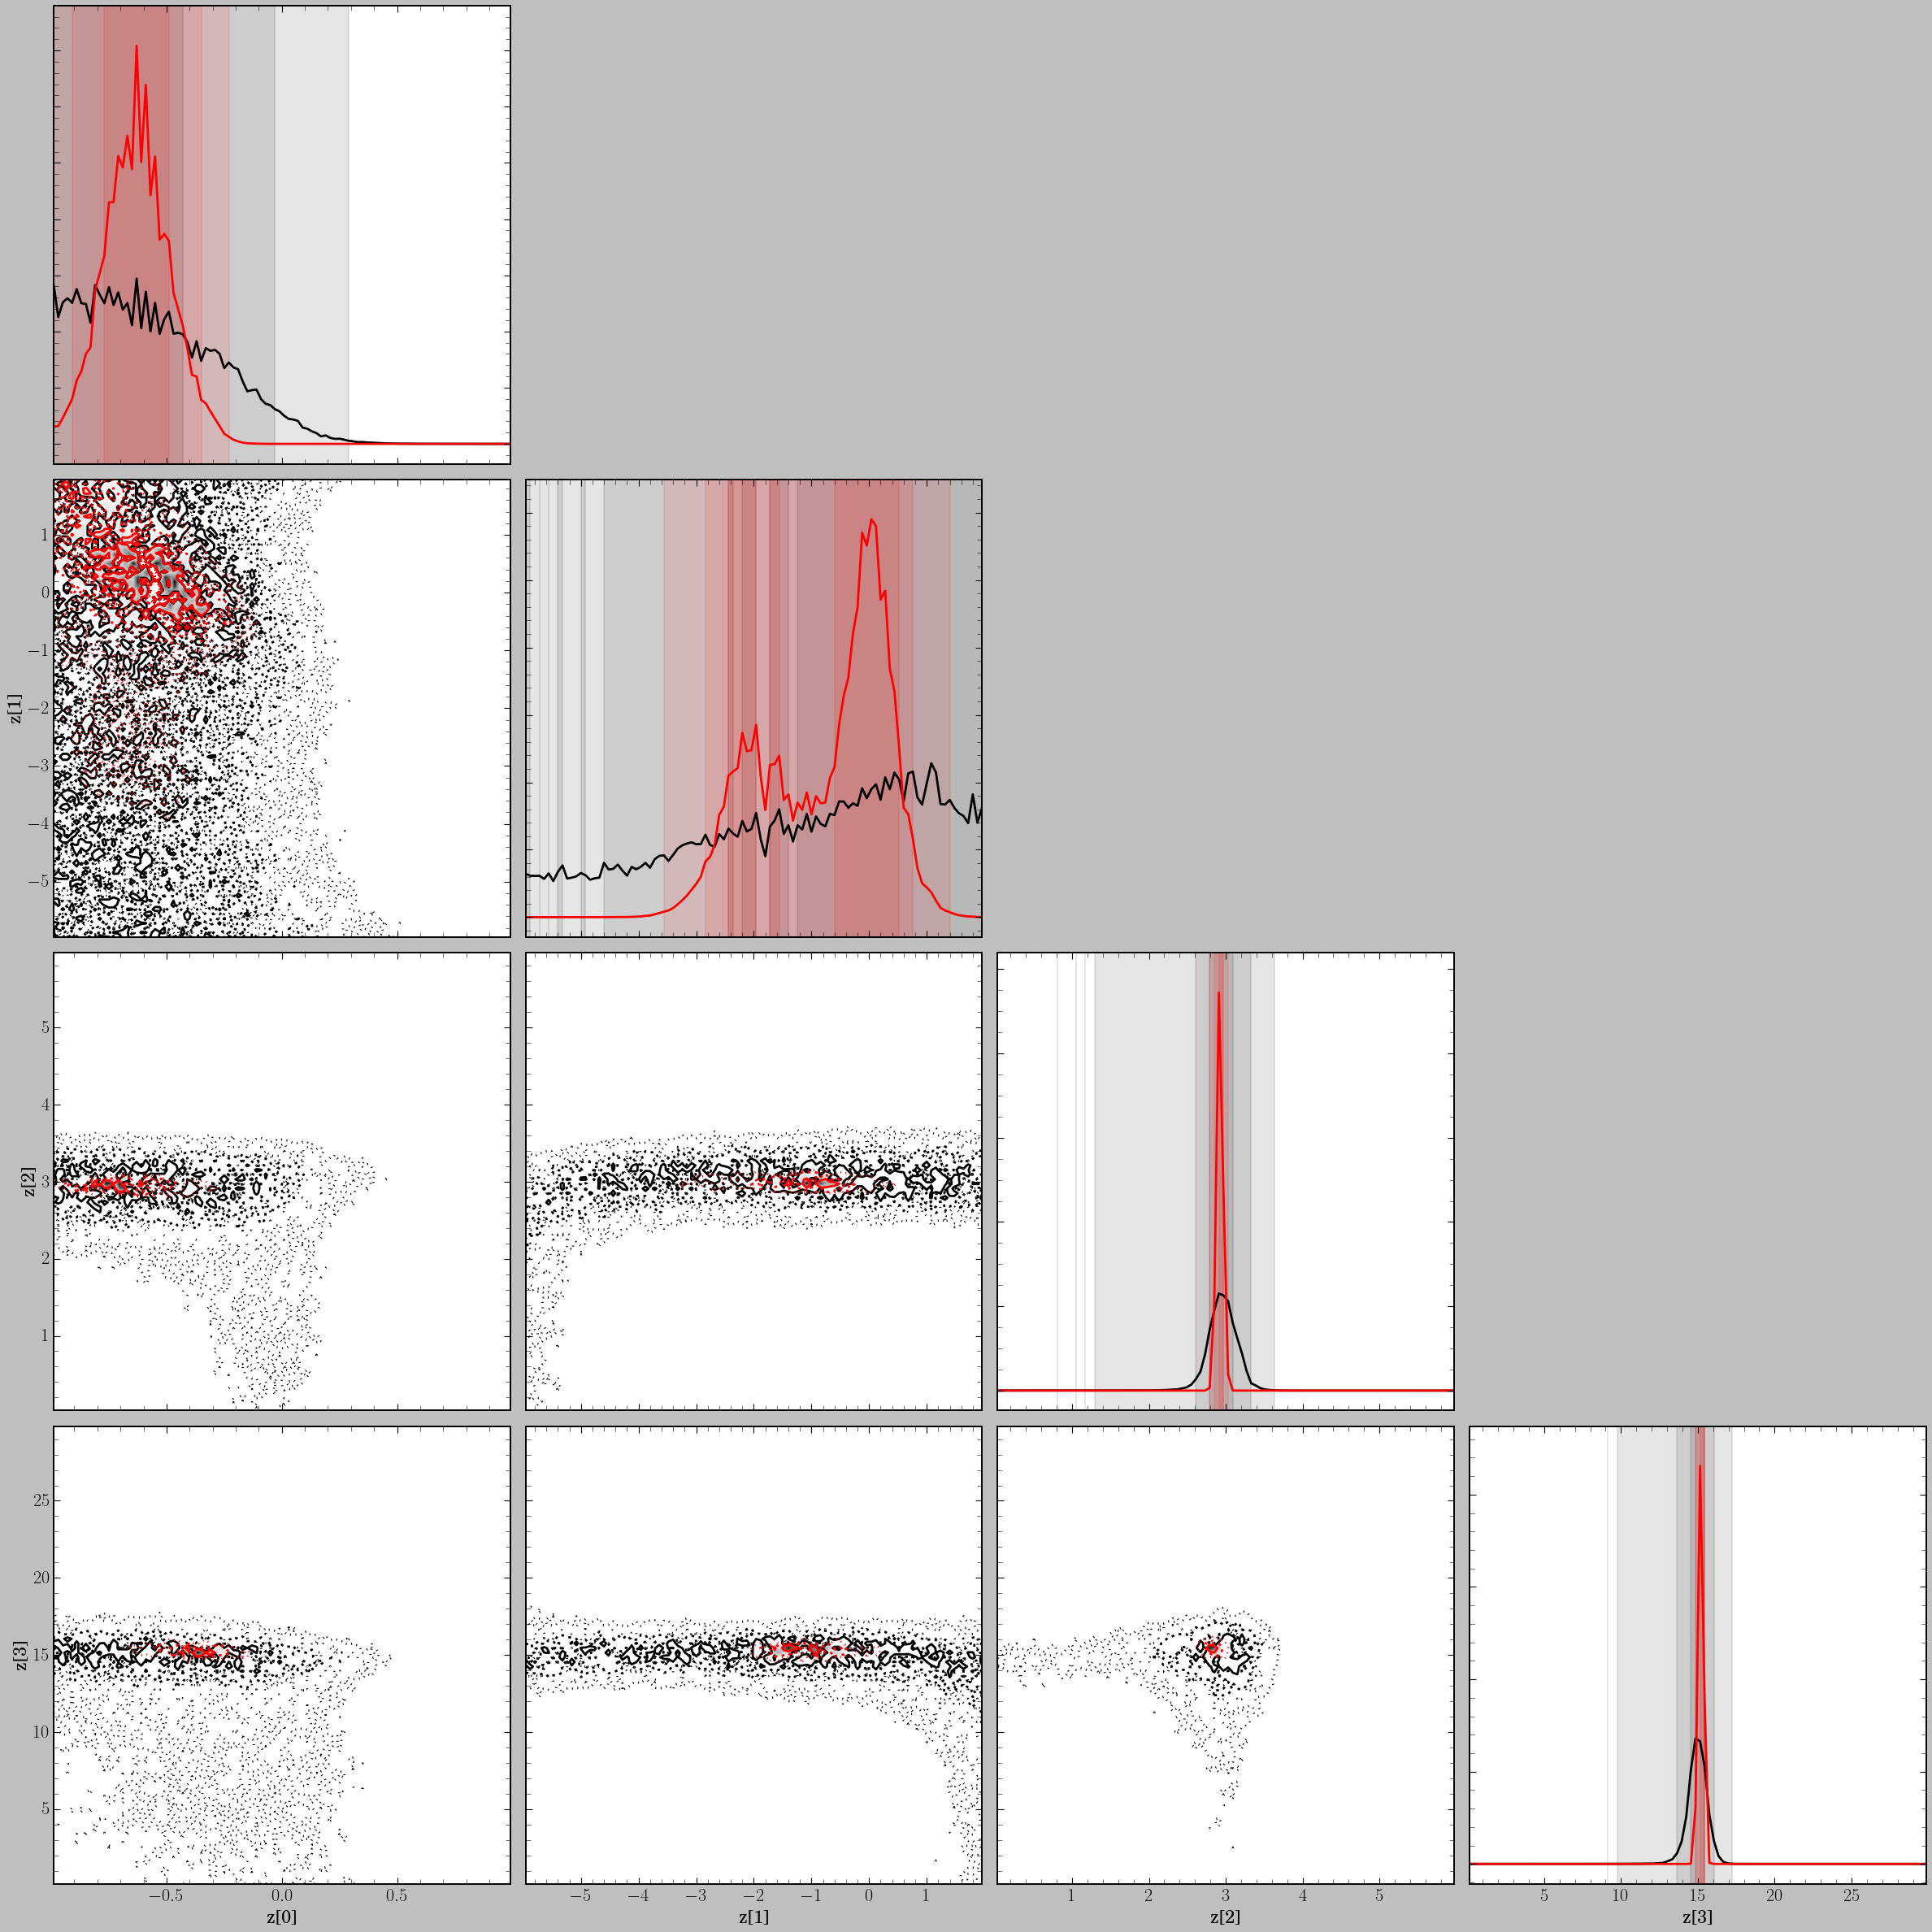

In [36]:
swyft.plot_corner(predictions, parnames=["z[0]", "z[1]", "z[2]", "z[3]"], figsize=(30, 30));
swyft.plot_corner([logratios_total_1d, logratios_total_2d], parnames=["z[0]", "z[1]", "z[2]", "z[3]"], fig=plt.gcf(), color='r');

In [61]:
swyft.collect_rect_bounds(logratios_total_1d, "z", (4,), threshold=1e-6)

tensor([[-0.4061,  0.2027],
        [-3.4180,  1.3163],
        [ 2.7702,  3.2540],
        [13.6720, 16.0070]])

In [216]:
new_bounds = swyft.collect_rect_bounds(
    predictions[0], "z", (2,), threshold=1e-6
)
new_bounds

tensor([[0.5000, 0.8748],
        [1.0000, 2.9999]])

In [56]:
sim = Gaussian(100, 2, new_bounds)

In [57]:
database = sim.sample(100000)

100%|██████████| 100000/100000 [00:02<00:00, 33830.81it/s]


In [58]:
means = np.mean(database["x"], axis=0)
network = InferenceNetwork(means, sim)
trainer = swyft.SwyftTrainer(accelerator="cpu")
dm = swyft.SwyftDataModule(database, batch_size=64)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [59]:
trainer.fit(network, dm)

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name  | Type                   | Params
-------------------------------------------------
0 | fc1   | Linear                 | 202   
1 | lrs1d | LogRatioEstimator_1dim | 34.9 K
2 | lrs2d | LogRatioEstimator_Ndim | 17.5 K
-------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)


/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 10:  13%|█▎        | 201/1563 [00:05<00:34, 38.99it/s, loss=-3.3, v_num=5, val_loss=-3.30] 

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [60]:
predictions = trainer.infer(network, observation, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 98/98 [00:03<00:00, 31.93it/s]


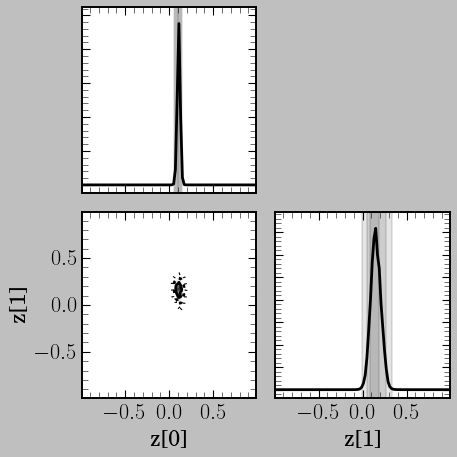

In [61]:
swyft.plot_corner(predictions, parnames=["z[0]", "z[1]"])

In [66]:
bounds = torch.tensor([[-0.3, 0.3], [-0.3, 0.3]])
sim = Gaussian(100, 2, bounds)
database = sim.sample(100000)
means = np.mean(database["x"], axis=0)
network = InferenceNetwork(means, sim)
trainer = swyft.SwyftTrainer(accelerator="cpu")
dm = swyft.SwyftDataModule(database, batch_size=64)
trainer.fit(network, dm)

100%|██████████| 100000/100000 [00:02<00:00, 34683.35it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name  | Type                   | Params
-------------------------------------------------
0 | fc1   | Linear                 | 202   
1

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24:   8%|▊         | 119/1563 [00:03<00:36, 39.41it/s, loss=-2.86, v_num=8, val_loss=-2.76] 

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


100%|██████████| 100000/100000 [00:00<00:00, 253306.45it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Epoch 2:  30%|██▉       | 466/1563 [06:25<15:07,  1.21it/s, loss=-2.68, v_num=10, val_loss=-2.69]


(-0.3, 0.3)

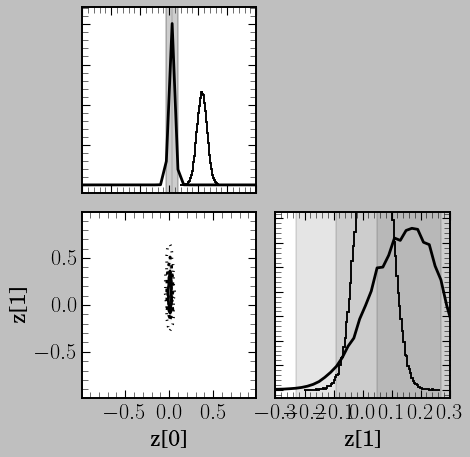

In [123]:
predictions = trainer.infer(
    network, observation, sim.sample(targets=["z"], N=100000)
)
swyft.plot_corner(predictions, parnames=["z[0]", "z[1]"])
ax = plt.subplot(2, 2, 1)
plt.hist(samples[:, 0], 100, color="k", histtype="step", density=True)
plt.xlim(-0.3, 0.3)
ax = plt.subplot(2, 2, 4)
plt.hist(samples[:, 1], 100, color="k", histtype="step", density=True)
plt.xlim(-0.3, 0.3)

In [75]:
def score(sample):
    trend_line = sim.x * sample["z"][0] + sample["z"][1]
    return np.array(
        [
            1.0 / 0.5**2 * np.dot((sample["x"] - trend_line), sim.x),
            1.0
            / 0.5**2
            * np.dot((sample["x"] - trend_line), np.ones_like(sim.x)),
        ]
    )

In [192]:
collect_net_samples = []
collect_score_samples = []
import tqdm

network.eval()
with torch.no_grad():
    network.eval()
    for i in tqdm.tqdm(range(1000)):
        sample = sim.sample()
        out = network.fc1(
            network.normalising_layer(
                (1 / 0.5**2) * (torch.tensor(sample["x"] - means[None, :]))
            )
        )
        collect_net_samples.append(out[0].numpy())
        collect_score_samples.append(score(sample))

100%|██████████| 1000/1000 [00:00<00:00, 11988.69it/s]


In [193]:
net_samples = np.vstack(collect_net_samples)
score_sample = np.vstack(collect_score_samples)

(array([ 1.,  0.,  1.,  0.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  0.,
         0.,  2.,  1.,  1.,  0.,  2.,  0.,  5.,  7.,  3.,  1.,  4.,  4.,
         5.,  5.,  6.,  7., 12.,  8.,  8., 14., 13., 22., 16., 29., 18.,
        23., 19., 35., 39., 40., 30., 36., 37., 46., 50., 34., 41., 49.,
        40., 28., 30., 23., 18., 26., 14., 20.,  9., 13.,  9.,  9., 12.,
         7.,  3.,  4.,  3.,  6.,  6.,  3.,  7.,  4.,  4.,  3.,  2.,  1.,
         0.,  2.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-3.04427558, -2.92002323, -2.79577089, -2.67151855, -2.54726621,
        -2.42301387, -2.29876152, -2.17450918, -2.05025684, -1.9260045 ,
        -1.80175216, -1.67749981, -1.55324747, -1.42899513, -1.30474279,
        -1.18049045, -1.0562381 , -0.93198576, -0.80773342, -0.68348108,
        -0.55922874, -0.43497639, -0.31072405, -0.18647171, -0.06221937,
         0.06203297,  0.18628532,  0.31053766,  0.43479   ,  0.559042

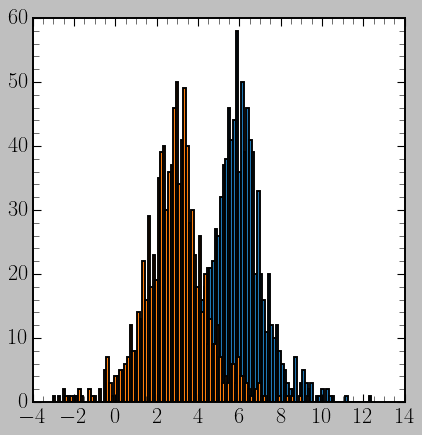

In [194]:
plt.hist(np.log(np.abs(score_sample[:, 0] / net_samples[:, 0])), bins=100)
plt.hist(np.log(np.abs(score_sample[:, 1] / net_samples[:, 1])), bins=100)

In [98]:
net_samples = np.vstack(collect_net_samples)
score_sample = np.vstack(collect_score_samples)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  2.,  2.,  0.,  0.,
         3.,  3.,  2.,  1.,  2.,  1.,  2.,  3.,  4.,  2.,  4.,  5., 14.,
         7., 12., 17., 10., 16., 16.,  9., 24., 17., 15., 23., 38., 33.,
        42., 48., 28., 38., 38., 45., 44., 40., 41., 32., 40., 42., 21.,
        32., 24., 13., 16., 10., 15.,  8., 13.,  9., 11., 10.,  5.,  6.,
         3.,  2.,  1.,  4.,  4.,  1.,  2.,  3.,  2.,  3.,  3.,  1.,  1.,
         2.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([-7.01903644, -6.89197182, -6.7649072 , -6.63784258, -6.51077796,
        -6.38371334, -6.25664872, -6.1295841 , -6.00251948, -5.87545486,
        -5.74839024, -5.62132562, -5.494261  , -5.36719638, -5.24013176,
        -5.11306714, -4.98600252, -4.8589379 , -4.73187328, -4.60480866,
        -4.47774404, -4.35067942, -4.2236148 , -4.09655018, -3.96948556,
        -3.84242094, -3.71535632, -3.5882917 , -3.46122708, -3.334162

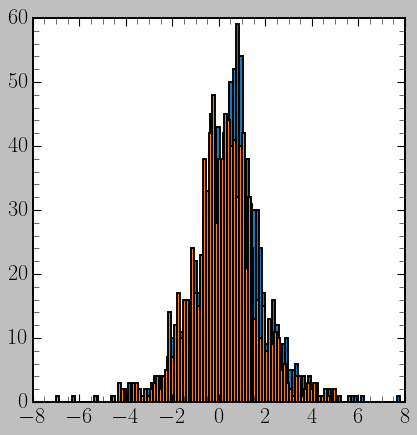

In [99]:
plt.hist(np.log(np.abs(score_sample[:, 0] / net_samples[:, 0])), bins=100)
plt.hist(np.log(np.abs(score_sample[:, 1] / net_samples[:, 1])), bins=100)

In [107]:
def log_prob(theta, x):
    mu = theta[0] * sim.x + theta[1]
    diff = x - mu
    return -(1 / (2 * 0.5**2)) * np.dot(diff, diff)


ndim = 2
nwalkers = 32
p0 = -2 * np.random.rand(nwalkers, ndim) + 1
import emcee

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=[observation["x"]]
)
state = sampler.run_mcmc(p0, 100)
sampler.reset()
sampler.run_mcmc(state, 10000)

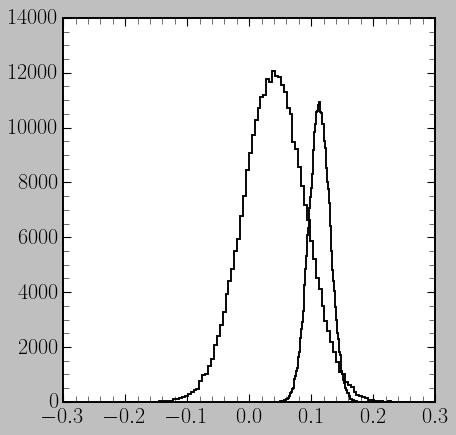

In [108]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.hist(samples[:, 1], 100, color="k", histtype="step")